# PiML Toolbox: High-code Demo for BikeSharing Data

This example notebook demonstrates how to use PiML with its high-code APIs for developing machine learning models for the BikeSharing data from UCI repository, which consists of 17,389 samples of hourly counts of rental bikes in Capital bikeshare system; see details [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset). 

The response `cnt` (hourly bike rental counts) is continuous and it is a regression problem.

# Install PiML Toolbox

1. Run `!pip install piml` to install the latest version of PiML
2. In Google Colab, we need restart the runtime in order to use newly installed version

In [1]:
!pip install piml

In [2]:
from piml import Experiment
exp = Experiment(highcode_only=True)

# Load and Prepare Data

In [3]:
# Choose BikeSharing
exp.data_loader(data='BikeSharing')

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,16.0
1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,40.0
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,32.0
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,13.0
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,1.0,12.0,19.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,119.0
17375,1.0,1.0,12.0,20.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,89.0
17376,1.0,1.0,12.0,21.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642,90.0
17377,1.0,1.0,12.0,22.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343,61.0


In [4]:
# Exclude these features one-by-one: "season", "workingday", "atemp" (highly correlated with others)
exp.data_summary(feature_exclude=["season", "workingday", "atemp"])

HTML(value='Data Shape:(17379, 13)')

In [5]:
# Prepare dataset by setting target, task type and train-test split
exp.data_prepare(target='cnt', task_type='Regression', test_ratio=0.2, random_state=0)

,Config,Value
0,Excluded columns,"[workingday, atemp, season]"
1,Target variable,cnt
2,Sample weight,None
3,Task type,Regression
4,Split method,Random
5,Test ratio,0.2
6,Random state,0
7,Train test energy distance,0.000404


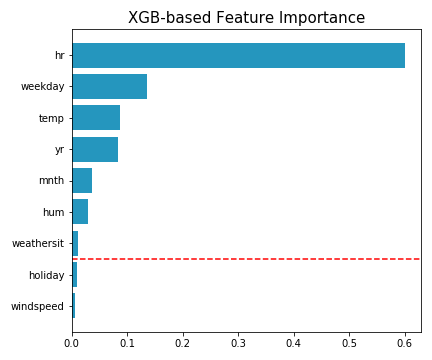

In [6]:
# Optional: select features by LightGBM feature importance 
exp.feature_select(threshold=0.98, method="pfi", figsize=(6, 5))

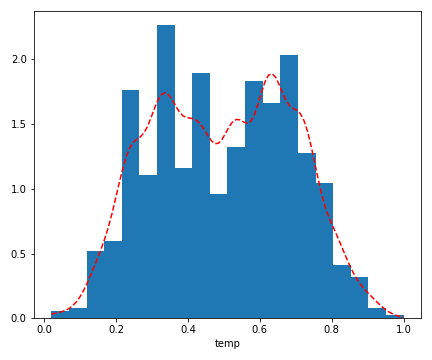

In [7]:
# Exploratory data analysis, check distribution and correlation
exp.eda(show='univariate', uni_feature='temp', figsize=(6, 5))

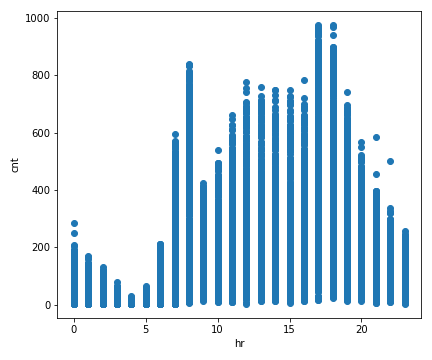

In [8]:
exp.eda(show='bivariate', bi_features=['hr', 'cnt'], figsize=(6, 5))

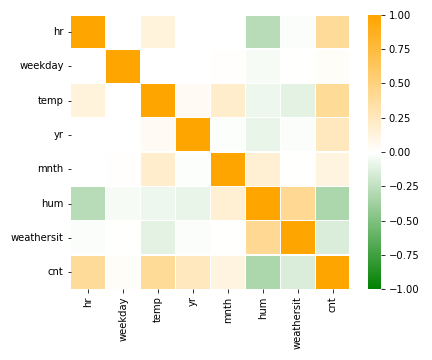

In [9]:
exp.eda(show='multivariate', multi_type='correlation_heatmap', figsize=(6, 5))

# Train intepretable models

In [10]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization
from piml.models import ReluDNNRegressor

model1 = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=model1, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0044,0.0457,0.8715
Test,0.0051,0.0492,0.8535
Gap,0.0007,0.0035,-0.0180


In [11]:
## GAMI-Net: GAM-Neural Networks with Structured Interactions
from piml.models import GAMINetRegressor

model2 = GAMINetRegressor(interact_num=10, loss_threshold=0.01,  
                        subnet_size_main_effect=[20], 
                        subnet_size_interaction=[20,20])
exp.model_train(model=model2, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0034,0.0395,0.9003
Test,0.0038,0.0423,0.8907
Gap,0.0004,0.0028,-0.0096


In [12]:
## EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

model3 = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=model3, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0064,0.0554,0.8149
Test,0.0069,0.0573,0.8039
Gap,0.0005,0.0019,-0.0110


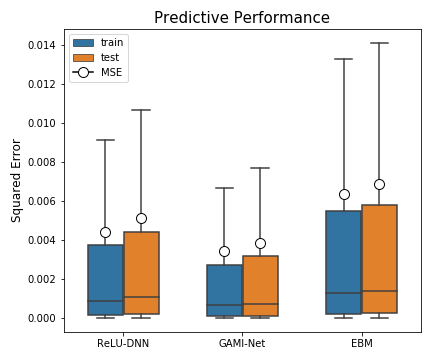

In [13]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy_plot', metric="MSE", figsize=(6, 5))

# Explainability and Interpretability

## Post-hoc Explainability: Global and Local Methods

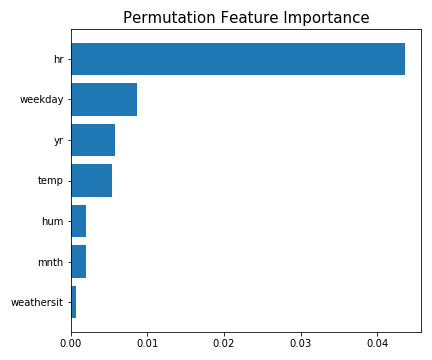

In [14]:
exp.model_explain(model='GAMI-Net', show='pfi', figsize=(6, 5))

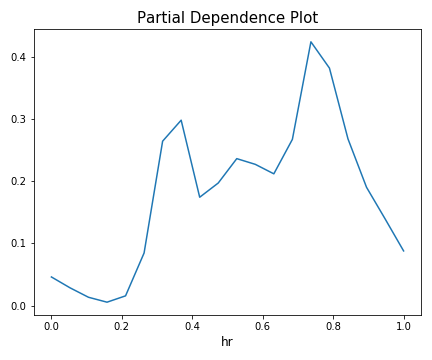

In [15]:
exp.model_explain(model='GAMI-Net', show='pdp', uni_feature='hr', figsize=(6, 5))

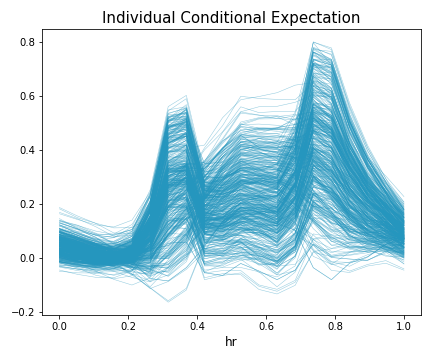

In [16]:
exp.model_explain(model='GAMI-Net', show='ice', uni_feature="hr", figsize=(6, 5))

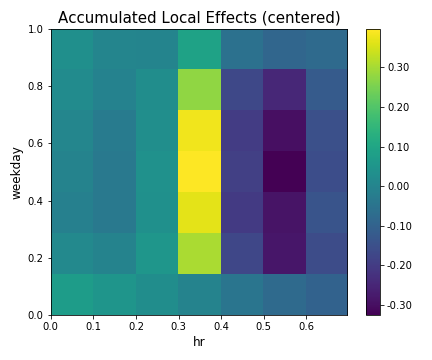

In [17]:
exp.model_explain(model='GAMI-Net', show='ale', bi_features=['hr', 'weekday'], figsize=(6, 5))

Exact explainer: 21it [00:10,  2.53s/it]                                                                               


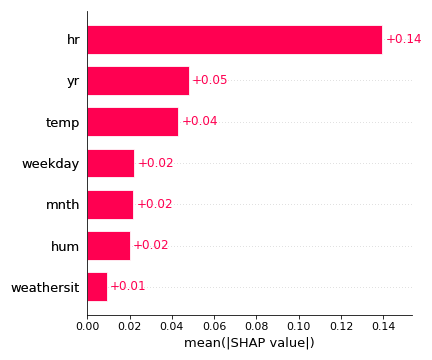

In [18]:
exp.model_explain(model='GAMI-Net', show='shap_fi', sample_size=20, figsize=(6, 5))

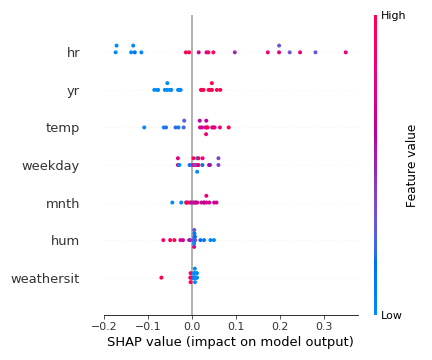

In [19]:
exp.model_explain(model='GAMI-Net', show='shap_summary', sample_size=20, figsize=(6, 5))

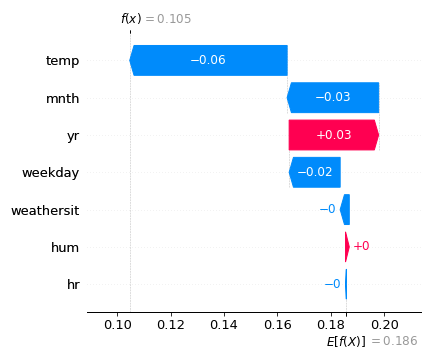

In [20]:
exp.model_explain(model='GAMI-Net', show='shap_waterfall', sample_id=0, figsize=(6, 5))

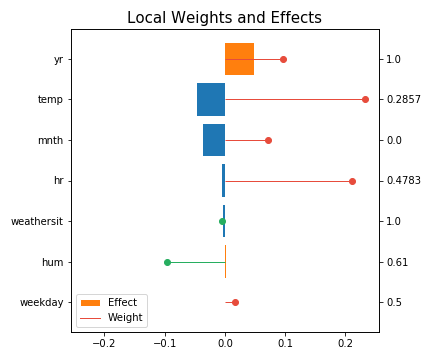

In [21]:
exp.model_explain(model='GAMI-Net', show='lime', sample_id=0, figsize=(6, 5))

## Inherent Interpretability: Global and Local Methods
 


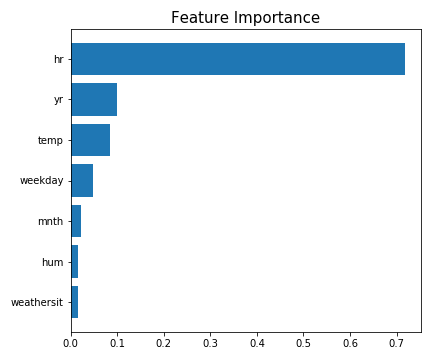

In [22]:
exp.model_interpret(model='GAMI-Net', show='global_fi', figsize=(6, 5))

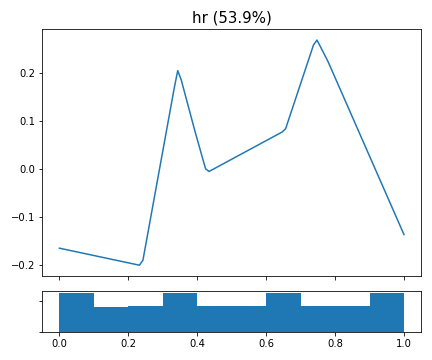

In [23]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', uni_feature='hr', figsize=(6, 5))

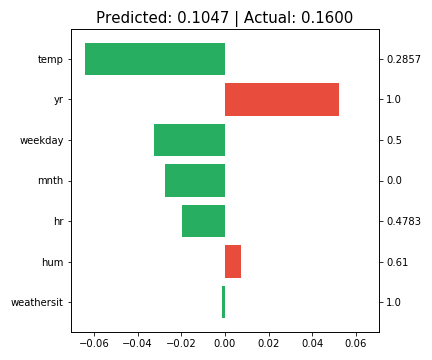

In [24]:
exp.model_interpret(model='GAMI-Net', show='local_fi', sample_id=0, figsize=(6, 5))

# Model Diagnostics and Outcome Testing

In [25]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0034,0.0395,0.9003
Test,0.0038,0.0423,0.8907
Gap,0.0004,0.0028,-0.0096


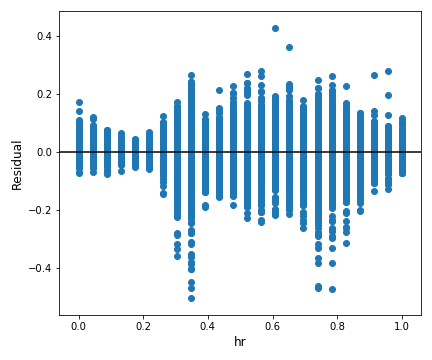

In [26]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_residual', target_feature='hr', figsize=(6, 5))

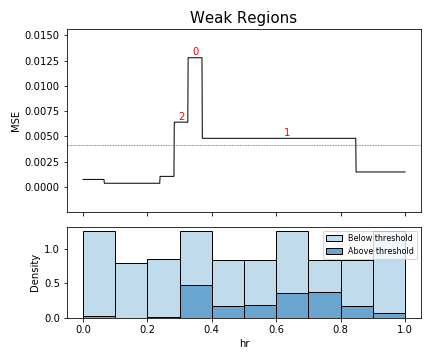

In [27]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['hr'], 
                   slice_method='tree', threshold=1.2, min_samples=20, figsize=(6, 5))

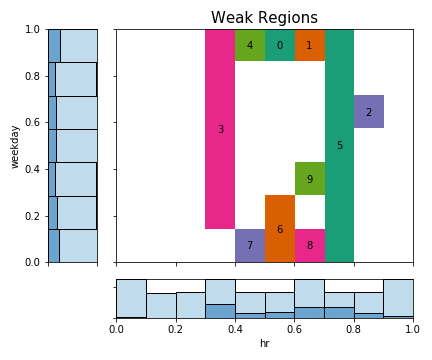

In [28]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['hr', 'weekday'], 
                   slice_method='histogram', threshold=1.2, min_samples=20, figsize=(6, 5))

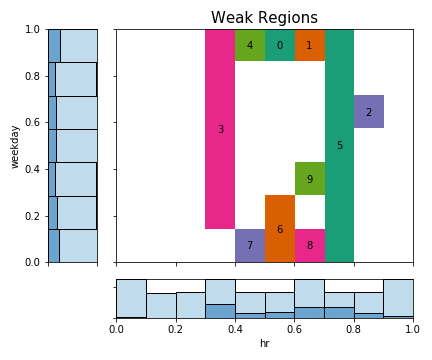

In [29]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['hr', 'weekday'], return_data=True,
                   slice_method='histogram', threshold=1.2, min_samples=20, figsize=(6, 5))

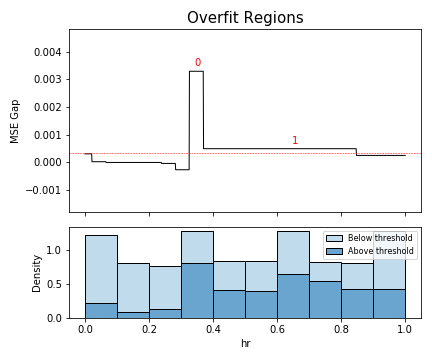

In [30]:
exp.model_diagnose(model='GAMI-Net', show='overfit', slice_features=['hr'], 
                   slice_method='tree', threshold=1.1, min_samples=20, figsize=(6, 5))

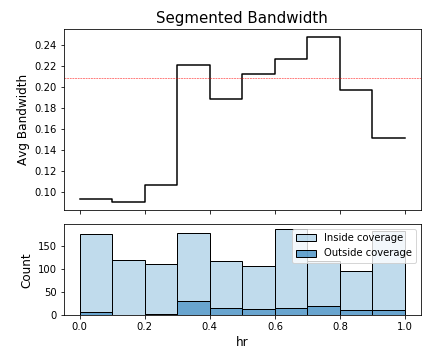

In [31]:
exp.model_diagnose(model='GAMI-Net', show='reliability_marginal', alpha=0.1, 
                   target_feature='hr', threshold=1.2, bins=10, figsize=(6, 5))

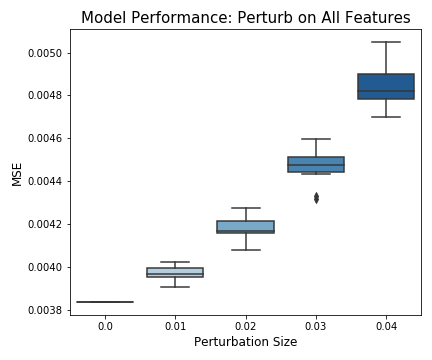

In [32]:
exp.model_diagnose(model='GAMI-Net', show='robustness_perf', perturb_features=None, perturb_size=0.01, figsize=(6, 5))

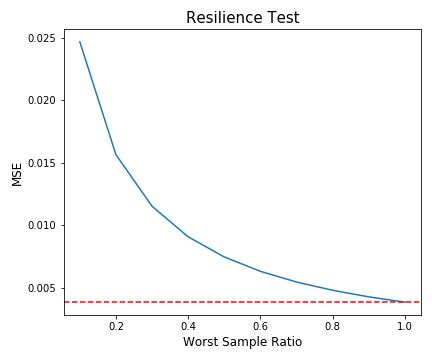

In [33]:
exp.model_diagnose(model='GAMI-Net', show='resilience_perf', target_feature='hr', figsize=(6, 5))

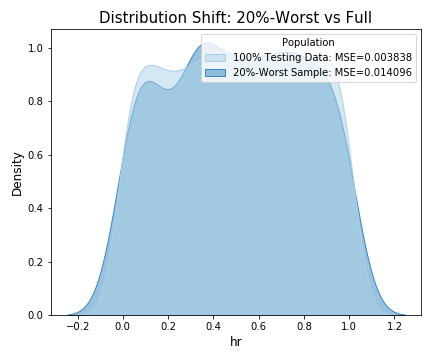

In [34]:
exp.model_diagnose(model='GAMI-Net', show='resilience_shift_density', immu_feature='hr', target_feature='hr', alpha=0.2, figsize=(6, 5))

# Model Comparison and Benchmarking

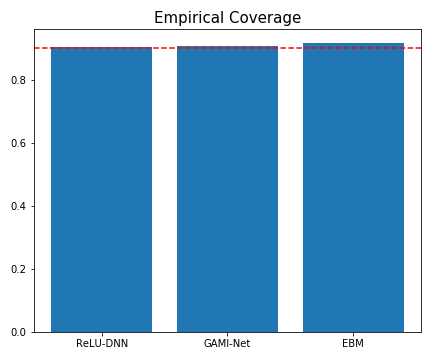

In [35]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_coverage', alpha=0.1, figsize=(6, 5))

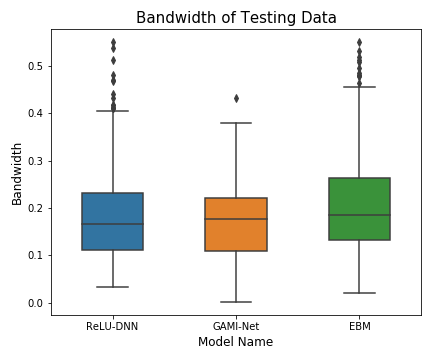

In [36]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_bandwidth', alpha=0.1, figsize=(6, 5))

In [37]:
exp.model_diagnose(model='ReLU-DNN', show='reliability_table', alpha=0.1, figsize=(6, 5))

,Empirical Coverage,Average Bandwidth
0,0.904317,0.177586


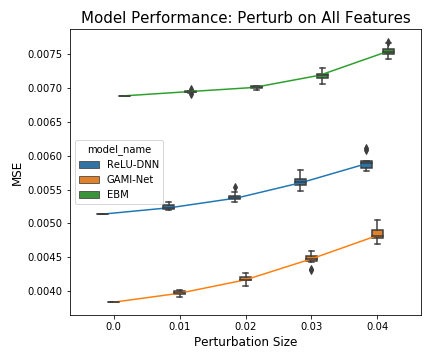

In [38]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf', 
                  perturb_features=None, perturb_size=0.01, figsize=(6, 5))

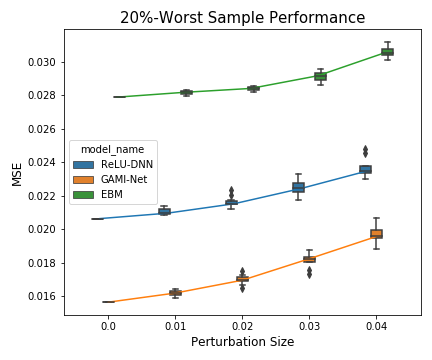

In [39]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf_worst', 
                  perturb_features=None, perturb_size=0.01, alpha=0.2, figsize=(6, 5))

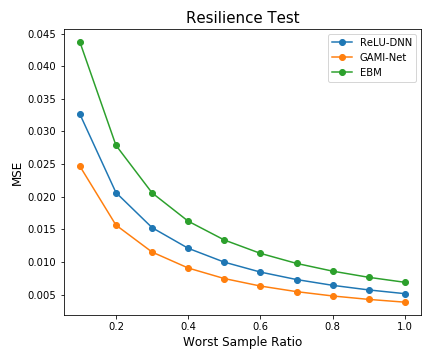

In [40]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_perf', figsize=(6, 5))

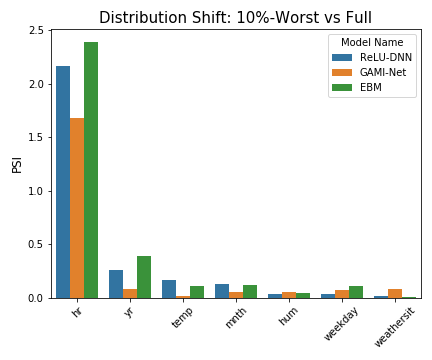

In [41]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_distance', figsize=(6, 5))